In [45]:
import requests
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import JOIN_STYLE
import matplotlib.pyplot as plt

In [46]:
url = 'https://deepstatemap.live/api/history/last'

# Execute GET request to fetch raw map state
response = requests.get(url)

# Check HTTP 200 (Success)
response.status_code

200

In [47]:
deep_state_data_raw = response.json()

## 4. Geometry flattening (3D to 2D)
**Critical Step:** The API returns coordinates in `(x, y, z)` format (Longitude, Latitude, Altitude). Most 2D analysis tools fail if Z-coordinates are present.

We loop through the features and use `shapely.wkt` to serialize the shape to text while forcing `output_dimension=2`, effectively dropping the Z-axis.

In [48]:
geo_list = []

for f in deep_state_data_raw['map']['features']:
    geom = f['geometry']
    name = f['properties']['name']

    # Convert raw dict to Shape object -> Dump to WKT (Text) forcing 2D -> Load back to Shape
    # This effectively strips the 'Z' coordinate
    clean_geometry = wkt.loads(wkt.dumps(shape(geom), output_dimension=2))

    new_feature = {
      "name": name,
      "geometry": clean_geometry
    }

    geo_list.append(new_feature)

# Check total count of features retrieved
print(f"Total features extracted: {len(geo_list)}")

Total features extracted: 521


## 6. GeoDataFrame Construction
We convert the list of dicts into a `GeoDataFrame`. We explicitly set the CRS (Coordinate Reference System) to **EPSG:4326** (WGS84 - Standard Latitude/Longitude).

## Explanation of code below

1. `raw_deepstatemap_gdf = gpd.GeoDataFrame(geo_list)`
What it does: This converts geo_list (which is a standard Python list of dictionaries) into a GeoDataFrame.

Why it matters: A GeoDataFrame is the core data structure of the geopandas library. It looks like a standard Excel spreadsheet or Pandas DataFrame, but it has a special "geometry" column that understands shapes (Points, Polygons). This allows you to perform spatial operations like calculating areas, merging boundaries, or checking if a point is inside a region.

2. `raw_deepstatemap_gdf = raw_deepstatemap_gdf.set_crs(4326)`
What it does: This tells the GeoDataFrame that the coordinates inside it are using the EPSG:4326 standard.

The Translation: EPSG:4326 is the code for WGS84, which is the standard latitude/longitude system used by GPS, Google Maps, and most online mapping tools.

Why it matters: Without this line, the computer just sees numbers like (37.5, 48.2). By setting the CRS, you are telling the computer, "These numbers represent degrees on the curved surface of the Earth." This is critical for accurate mapping and area calculations later.

In [49]:
def extract_first_part(name, part=0):
    """Splits the DeepState name string and returns the specific index requested."""
    first_part = name.split('///')[part].strip()
    return first_part

# Apply translation to all items in the list (Index 1 = English)
for item in geo_list:
    item['name'] = extract_first_part(item['name'], part=1)

In [50]:
raw_deepstatemap_gdf = gpd.GeoDataFrame(geo_list)
raw_deepstatemap_gdf = raw_deepstatemap_gdf.set_crs(4326)


In [51]:
points = raw_deepstatemap_gdf[
    raw_deepstatemap_gdf.geometry.apply(lambda x: isinstance(x, Point))
].copy()

print(f"Polygons remaining: {len(points)}")

Polygons remaining: 408


In [52]:
points

,name,geometry
108,Russian cruiser Moskva,POINT (30.92515 45.17872)
109,Direction of attack,POINT (36.82591 48.06571)
110,Direction of attack,POINT (37.70018 49.50677)
111,Kyiv,POINT (30.52424 50.45006)
112,Minsk,POINT (27.55887 53.90216)
...,...,...
516,Air Base Ostrov,POINT (28.42118 57.29159)
517,Akhtubinsk Aerodrom,POINT (46.20243 48.30862)
518,Volgograd International Airport,POINT (44.34387 48.78517)
519,Airport «Vytyazevo»,POINT (37.34117 45.00282)


In [53]:
polygons = raw_deepstatemap_gdf[
    raw_deepstatemap_gdf.geometry.apply(lambda x: isinstance(x, Polygon))
].copy()

print(f"Polygons remaining: {len(polygons)}")

Polygons remaining: 113


set_crs(4326) only labels the data as WGS84 lat/lon in degrees; you still need to reproject to a meter-based CRS before using .area for meaningful areas

In [54]:
polygons = polygons.to_crs(epsg=32636)

In [55]:
polygons['name'].unique()

array(['Unknown status', 'Occupied', 'Transnistria',
       'Occupied Tskhinvali district', 'Occupied Tuzla Island',
       'CADR and CALR', 'Occupied Crimea',
       'East Prussia is temporarily occupied.', 'Occupied Abkhazia.',
       'The temporarily occupied territory of Karelia.',
       'The temporarily occupied territory of the Republic of Ichkeria.',
       'Liberated', 'Liberated 25.03', 'Liberated 16.03-17.03',
       'Liberated 23.03', 'Liberated 27-31.03', 'Liberated 26.03',
       'Liberated 27-29.03', 'Liberated 30.03', 'Liberated 05.04',
       'Liberated 31.03', 'Liberated 02.07', 'Liberated 30.05',
       'Snake Island', 'Liberated 26.06', 'Liberated 04.09',
       'Occupied Petsamo', 'Occupied Salla',
       'occupied Estonia territories.',
       'Occupied Pechorsky district (Saaste Boot).',
       'Occupied Latvia territories.', 'Occupied Southern Kuril islands.',
       'Liberated 31.03 - 02.04'], dtype=object)

In [56]:
targets = ['CADR and CALR', 'Occupied', 'Occupied Crimea']

occupied_areas = polygons[
     polygons['name'].isin(targets)
].copy().reset_index()



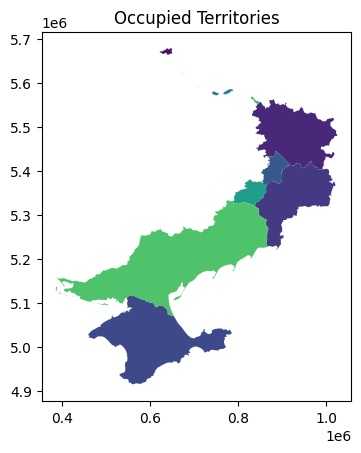

In [57]:
occupied_areas.plot(cmap='viridis')
plt.title("Occupied Territories")
plt.show()



In [58]:
liberated_areas = polygons[
    polygons["name"].str.contains("liberated", case=False, na=False)
].copy().reset_index(drop=True)

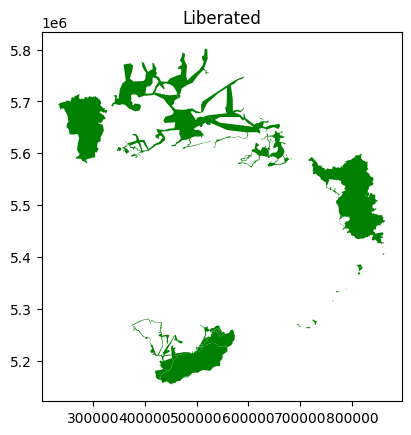

In [59]:
liberated_areas.plot(color="green")
plt.title("Liberated")
plt.show()

In [60]:
gray_areas = polygons[
    polygons["name"].str.contains("unknown", case=False, na=False)
].copy().reset_index(drop=True)


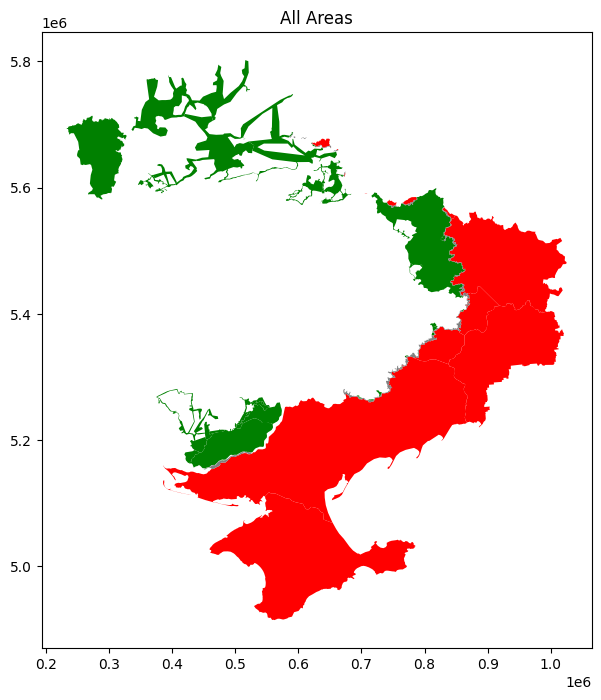

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))

occupied_areas.plot(ax=ax, color="red")
liberated_areas.plot(ax=ax, color="green")
gray_areas.plot(ax=ax, color="gray")

ax.set_title("All Areas")
plt.show()


In [62]:
km = 1000000

print("liberated areas km²", int(liberated_areas.area.sum()/ km))
print("occupied areas km²", int(occupied_areas.area.sum() / km))
print("gray areas km²", int(gray_areas.area.sum()/ km))


liberated areas km² 41365
occupied areas km² 116366
gray areas km² 1396


# DEBUG SECTION


In [63]:
polygons.columns

Index(['name', 'geometry'], dtype='object')

In [64]:
import pandas as pd

polygons['dt'] = pd.to_datetime(deep_state_data_raw['id'], unit='s')
polygons['id'] = deep_state_data_raw['id']

polygons = polygons.set_index('dt')


In [65]:
polygons = polygons[
    polygons.geometry.apply(lambda x: isinstance(x, Polygon))
].copy()

polygons

,name,geometry,id
dt,,,
2026-01-01 20:54:06,Unknown status,"POLYGON ((856293.921 5403561.536, 855398.859 5...",1767300846
2026-01-01 20:54:06,Unknown status,"POLYGON ((690835.288 5268983.477, 690925.319 5...",1767300846
2026-01-01 20:54:06,Unknown status,"POLYGON ((843158.908 5448652.24, 843029.345 54...",1767300846
2026-01-01 20:54:06,Unknown status,"POLYGON ((732183.57 5273557.308, 733543.663 52...",1767300846
2026-01-01 20:54:06,Unknown status,"POLYGON ((710929.372 5261585.651, 711209.078 5...",1767300846
...,...,...,...
2026-01-01 20:54:06,Unknown status,"POLYGON ((587913.272 5682010.349, 587493.338 5...",1767300846
2026-01-01 20:54:06,Liberated,"POLYGON ((589591.005 5686317.548, 589536.345 5...",1767300846
2026-01-01 20:54:06,Occupied,"POLYGON ((663095.428 5660310.876, 662934.504 5...",1767300846


In [66]:
from ipyleaflet import Map, basemaps, GeoJSON
from shapely import wkt
import json

polygons = polygons.to_crs(epsg=4326)

wkt_str = f"{polygons.iloc[0]['geometry']}"

wkt_str


poly = wkt.loads(wkt_str)

# Shapely uses (x, y) = (lon, lat); Leaflet expects [lat, lon]
coords_lonlat = list(poly.exterior.coords)
coords_latlon = [[lat, lon] for lon, lat in coords_lonlat]

geojson = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [coords_lonlat],  # GeoJSON expects [lon, lat]
    },
    "properties": {"name": "My polygon"},
}

# Center map on polygon centroid
centroid = poly.centroid
m = Map(
    center=(centroid.y, centroid.x),
    zoom=11,
    basemap=basemaps.OpenStreetMap.Mapnik  # DeepState uses MapTiler, but OSM is fine visually
)

layer = GeoJSON(
    data=geojson,
    style={
        "color": "red",
        "weight": 2,
        "fillColor": "red",
        "fillOpacity": 0.4,
    }
)

m.add(layer)

Map(center=[48.52925816436788, 37.811674917965206], controls=(ZoomControl(options=['position', 'zoom_in_text',…